# Import libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

import numpy as np
import matplotlib.pyplot as plt

# Load dataset

In [2]:
trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [4]:
testingset.shape

(3589, 2311)

# Split data

In [5]:
n_inputs = 48*48
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
#x_training.shape
x_training = np.expand_dims(x_training, axis=3)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=3)

In [6]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)


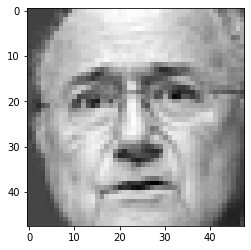

facial emotion: fear


In [7]:
print(x_training.shape)
print(y_training.shape)

print(x_testing.shape)
print(y_testing.shape)

sample = x_training[5, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[5, :]))

# Define model: a model in karas is a sequence of layers!

In [8]:
model = Sequential()

In [9]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))

In [10]:
model.add(Conv2D(64, (3, 3), activation='relu'))

In [11]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

In [13]:
model.add(Conv2D(128, (3, 3), activation='relu'))

In [14]:
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

In [15]:
model.add(Conv2D(256, (3, 3), activation='relu'))

In [16]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [17]:
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile model

In [18]:
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit model

In [19]:
batch_size = 128
n_epoches = 500
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

model.fit(x_training, y_training, batch_size=batch_size, epochs=n_epoches,
          validation_data=(x_testing, y_testing), shuffle=True,
          callbacks=[early_stopping])

Train on 28709 samples, validate on 3589 samples
Epoch 1/500
 4352/28709 [===>..........................] - ETA: 11:22 - loss: 8.3839 - accuracy: 0.1884WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

# Evaluate model

In [ ]:
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

In [ ]:
model.save('fer2013.h5')
model.save_weights('fer2013_weights.h5')

# Load trained model

In [20]:
model.load_weights('fer2013_weights.h5')

In [21]:
scores = model.evaluate(x_testing, y_testing)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

accuracy: 61.63%


***
# Test trained model

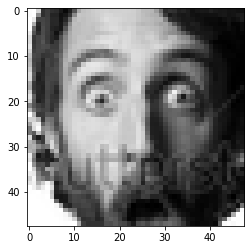

> testing image index: 2042
> true emotion: surprise
> predicted emotion: surprise


In [22]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

***
# Partial accuracy

In [24]:
for emo_indx in range(0, n_classes):
    data_for_class = testingset[testingset[:, 2304 + emo_indx] == 1]
    x_data = data_for_class[:, 0:2304]
    x_data = x_data.reshape(x_data.shape[0], 48, 48)
    x_data = np.expand_dims(x_data, axis=3)

    y_data = data_for_class[:, 2304:2304 + n_classes]

    scores = model.evaluate(x_data, y_data, batch_size=32, verbose=0)
    print('> Accuracy %.2f%% for <%s>'% (scores[1]*100, get_emotion(np.array([emo_indx]))))

> Accuracy 52.89% for <angry>
> Accuracy 51.79% for <disgust>
> Accuracy 38.31% for <fear>
> Accuracy 80.45% for <happy>
> Accuracy 54.36% for <sad>
> Accuracy 78.80% for <surprise>
> Accuracy 56.67% for <neutral>
